In [10]:
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
import xarray as xr
import zarr
import gcsfs
from tqdm.autonotebook import tqdm
import os
import cftime
import json
from dask import array

%matplotlib inline
plt.rcParams['figure.figsize'] = 12, 6
%config InlineBackend.figure_format = 'retina'

dfs = pd.DataFrame(name.split('_')[0:3] + [name.split('_')[3].replace('.npy','')] + [name] for name in os.listdir('pangeo_data') if name[0] != '.')
dfs = dfs.rename(columns={0:'source_id', 1:'experiment_id',2:'member_id',3:'variable_id',4:'file_name'})

In [86]:
def tcr_classic(ts_expt, ts_ctrl):
    m_expt = np.mean(ts_expt[0,60*12:80*12])
    m_ctrl = np.mean(ts_ctrl[0,60*12:80*12])
    std_expt = np.std(np.random.choice(ts_expt[0,60*12:80*12], 10000)) / np.sqrt(20)
    std_ctrl = np.std(np.random.choice(ts_expt[0,60*12:80*12], 10000)) / np.sqrt(20)
    return m_expt - m_ctrl, np.sqrt(np.sum(np.square([std_expt,std_ctrl])))

In [3]:
def moving_average(x, w):
    return np.convolve(x, np.ones(w), 'valid') / w    

In [4]:
def find(**keys):
    ndfs = dfs.copy()
    for k,v in keys.items():
        ndfs = ndfs[ndfs[k] == v]
    return ndfs

In [5]:
def load(**keys):
    ndfs = find(**keys)
    ns = np.array([[f, np.load('pangeo_data/'+f, allow_pickle = True)] for f in ndfs.file_name])
    return ns

In [17]:
def plot_time_var(window, delta=False, mintime=0, **keys):
    ts = load(**keys)
    
    if len(ts) == 0:
        print("No data fit these keys")
        return
    
    ts = np.array([[f,t] for f, t in ts if len(t[1]) >= mintime])
    dates = [d for d in [pd.to_datetime(n[1], errors='coerce') for n in ts[:,1]] if d[0] != 'NaT']
    plt.figure(' '.join(keys.values())+' runs')
    for f, v in sorted(ts, key=lambda x: x[0]):
        w = window
        var = moving_average(v[0] - int(delta) * np.mean(v[0,0:12]), w)
        d = next((d for d in dates if len(d) == len(v[0])),None)
        if isinstance(d, type(None)):
            continue
        plt.plot_date(d[int(w/2)-1:int(len(v[0])-w/2)], var, xdate=True, fmt='-', label=f)
    plt.title(' '.join(keys.values()), fontsize=24)
    plt.ylabel("$\Delta$"+keys['variable_id'], fontsize=18)
    plt.xlabel("Time (years)", fontsize=18)

Plot 10-year moving average $\Delta T$  for 1pctCO2 runs
=======

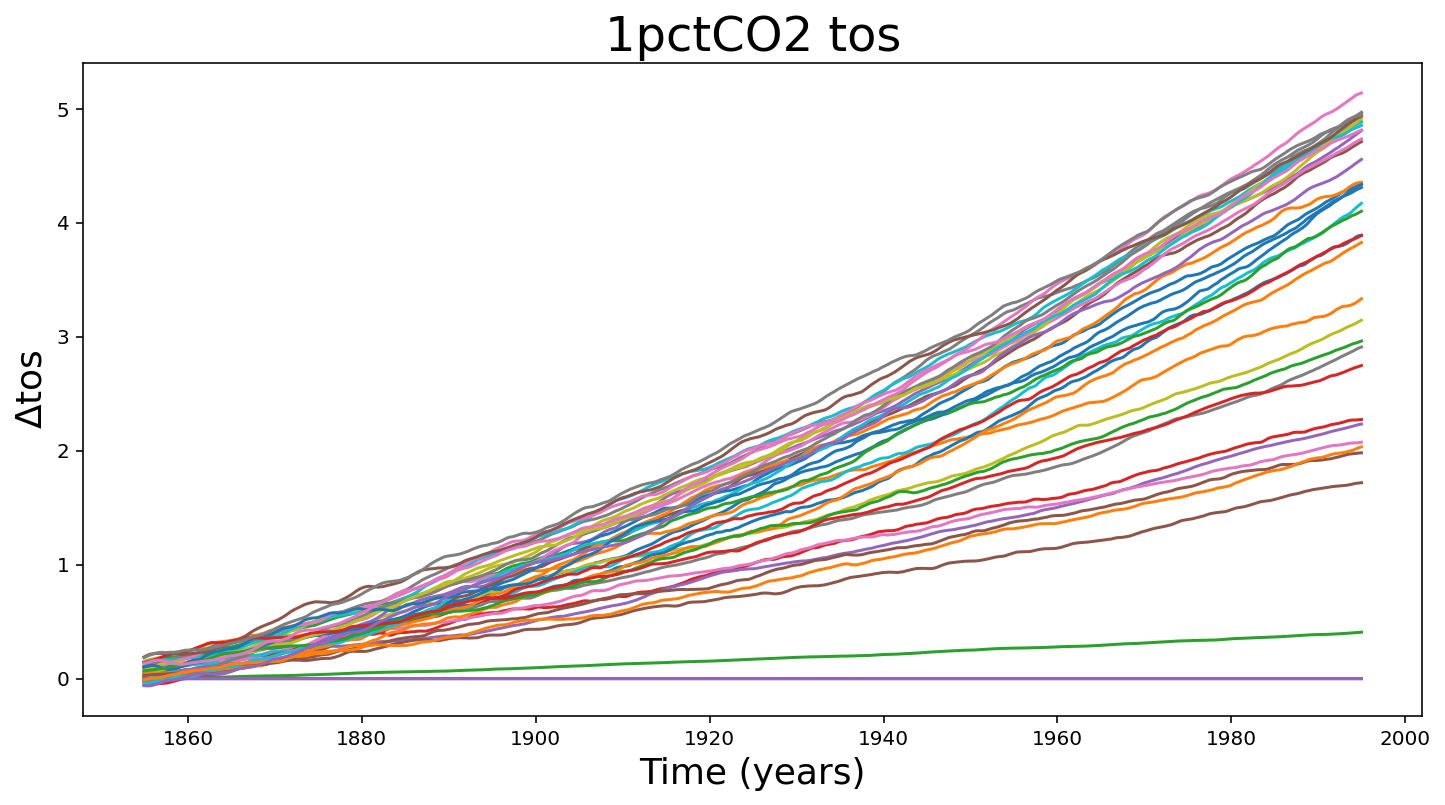

In [18]:
plot_time_var(window=10*12, delta=True, experiment_id = '1pctCO2', variable_id='tos')

Plot 10-year moving average $\Delta T$  for abrupt-4x runs
=======

ValueError: x and y must have same first dimension, but have shapes (0,) and (3,)

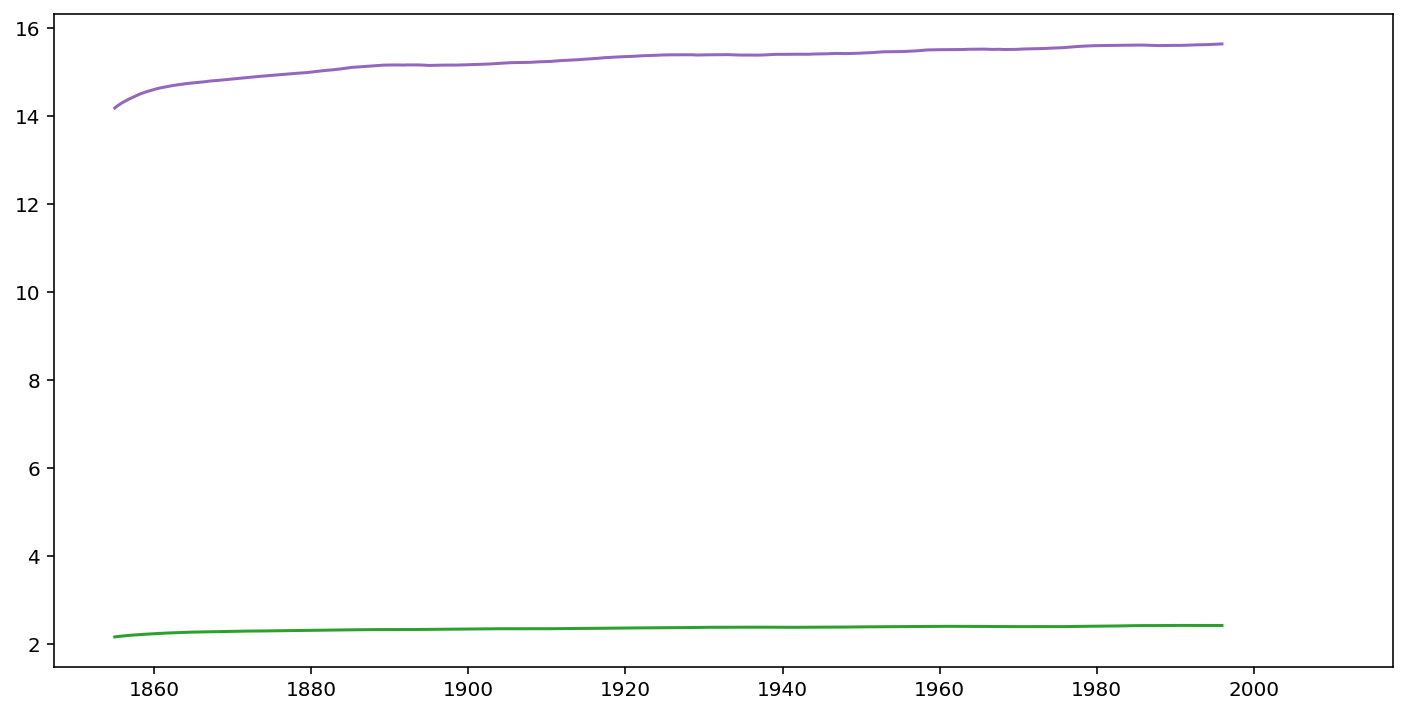

In [19]:
plot_time_var(window=10*12, delta=False, experiment_id = 'abrupt-4xCO2', variable_id='tos')

Get all TCRs using $\Delta T$ at $2 \times CO_2$
=========

In [87]:
def get_expt_ctrl(variable_id, experiment_id):
    all_dfs = []
    for f in dfs.groupby(["source_id","member_id","variable_id"]):
        if f[0][2] == variable_id:
            if experiment_id in f[1].experiment_id.values and "piControl" in f[1].experiment_id.values:
                all_dfs += [f[1]]
    return all_dfs

<ErrorbarContainer object of 3 artists>

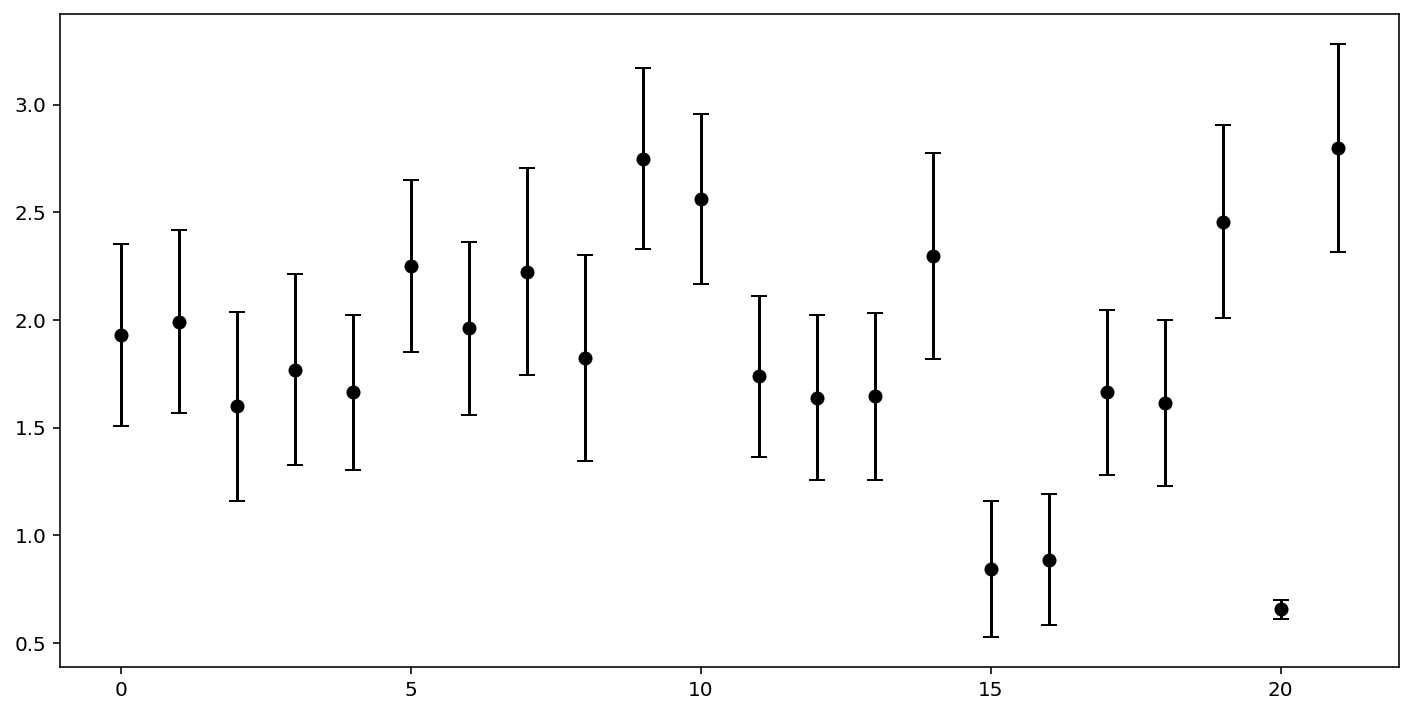

In [100]:
tcr_data = get_expt_ctrl('ts','1pctCO2')
tcrs = []
for d in tcr_data:
    pc = load(file_name=d[d['experiment_id']=='piControl'].file_name.values[0])
    ts = load(file_name=d[d['experiment_id']=='1pctCO2'].file_name.values[0])
    tcr, err = tcr_classic(ts[:,1][0], pc[:,1][0])
    tcrs += [[tcr, err]]
#     print(pc[0,0].split('_')[0] + "\n %f ± %f" % (tcr, err))
tcrs = np.array(tcrs)
plt.errorbar(x=list(range(len(tcrs))), y=tcrs[:,0], yerr=tcrs[:,1], fmt='ok', capsize=4)

In [89]:
ts[:,1][0][0]

array([285.8639221191406, 285.99725341796875, 286.86553955078125, ...,
       294.98114013671875, 293.8723449707031, 293.01837158203125],
      dtype=object)

In [ ]:
def percentiles(ds, df):
    Area = get_area(ds, df)
    Var = ds.get(ds.variable_id)
    
    percentiles = []
    
    for t in range(len(Var.time)):
        area = Area[t]
        var = Var[t]
        time = Var.time[t]
        
        weights = np.reshape(area.data, (np.prod(np.shape(var)),1))
        vals = np.reshape(var.data, (np.prod(np.shape(var)),1))
        weights = np.array(weights[~np.isnan(vals)])
        vals = np.array(vals[~np.isnan(vals)])

        idx = np.argsort(vals)
        vals = np.take_along_axis(vals, idx, axis=0)
        sorted_weights = np.array(np.take_along_axis(weights, idx, axis=0))
        total = np.nansum(weights)

        i = 0
        low = 0
        N = len(weights)
        pcts = np.array([0.05, 0.17, 0.5, 0.83, 0.95])
        pct_vals = []
        for j in range(0,len(vals)):
            low = low + sorted_weights[j]
            high = low + sorted_weights[min(j+1,N)]
            # If the cumulative weights are nearest the next percentile
            # Then mark down the value
            if low/total < pcts[i] and high/total >= pcts[i]:
                pct_vals += [[pcts[i], vals[j]]]
                if i == np.shape(pcts)[0] - 1:
                    break
                i = i + 1
                
        percentiles += [time, pct_vals]
    
    return percentiles